# 5A. ADI forward modeling of point sources

> Authors: *Valentin Christiaens* and *Carlos Alberto Gomez Gonzalez*  
> Suitable for VIP *v1.0.3* onwards  
> Last update: *2024/03/25*

**Table of contents**

* [5.1. Loading ADI data](#5.1.-Loading-ADI-data)
* [5.2. Generating and injecting synthetic planets](#5.2.-Generating-and-injecting-synthetic-planets)
* [5.3. Flux and position estimation with NEGFC](#5.3.-Flux-and-position-estimation-with-NEGFC)
    - [5.3.1. Nelder-Mead based optimization](#5.3.1.-Nelder-Mead-based-optimization)
    - [5.3.2. Planet subtraction](#5.3.2.-Planet-subtraction)
    - [5.3.3. NEGFC technique coupled with MCMC](#5.3.3.-NEGFC-technique-coupled-with-MCMC)
        - [5.3.3.1. Running the MCMC sampler](#5.3.3.1.-Running-the-MCMC-sampler)
        - [5.3.3.2. Visualizing the MCMC chain: corner plots and walk plots](#5.3.3.2.-Visualizing-the-MCMC-chain:-corner-plots-and-walk-plots)
        - [5.3.3.3. Highly probable values and confidence intervals](#5.3.3.3.-Highly-probable-values-and-confidence-intervals)
    - [5.3.4. NEGFC technique coupled with nested sampling](#5.3.4.-NEGFC-technique-coupled-with-nested-sampling)
    - [5.3.5. Residual speckle uncertainty](#5.3.5.-Residual-speckle-uncertainty)
    - [5.3.6. Final uncertainties](#5.3.6.-Final-uncertainties)

This tutorial shows:

- how to generate and inject fake companions in a cube;
- how to estimate the astrometry and photometry of a directly imaged companion, and associated uncertainties.

<div class="alert alert-block alert-info"> 
    <b>Speed tricks: </b>
<a class="anchor" id="note1"></a>

Depending on your machine, you may be able to run VIP more efficiently than with the default options:

- Most PSF subtraction routines in VIP (and some other functions) have been implemented in VIP to allow for **multiprocessing**, in order to optimally harness the power of machines equipped with multiple CPUs. Any function where the `nproc` parameter is available in its call can be run in multi-processing, with the value of `nproc` setting the requested number of CPUs to use. Instead of an integer, one can set `nproc=None` to use half of all available CPUs. For optimal results in multiprocessing, set the following environment parameters in your terminal **BEFORE** launching your Jupyter notebook:
    
`export MKL_NUM_THREADS=1`
    
`export NUMEXPR_NUM_THREADS=1`
    
`export OMP_NUM_THREADS=1`

- If a bit of interpolation at the moment of **image rotation** is not an issue for your data (instead of using the default FFT-based method implemented in VIP), and if you have `opencv` installed, you can get a significant speed gain in the image derotation that is involved in all ADI-based post-processing routines by setting `imlib = 'opencv'` in your call to the routine. Experience suggests that up to a factor 30x in speed gain can be achieved, see however Tutorial 8 for the impact of such assumption).

- If you have **FORTRAN** installed, it is recommended to switch the default mode considered for singular value decomposition done in all PCA-based algorithms to `svd_mode = 'arpack'`, instead of the default `'lapack'` based on numpy. Experience suggests up to a factor 2x in speed gain can be achieved.
 
- If you have access to a **GPU** and large image data cubes, you may want to attempt singular value decomposition calculation on GPU by setting `svd_mode` to an appropriate value for your machine (e.g. `'cupy'` or `'eigencupy'` to leverage the Cupy library for a similar SVD as performed with the 'Lapack' and 'eigen' options, respectively; `'pytorch'` or `'eigenpytorch'` : to leverage the Pytorch library for a similar SVD as performed with the 'Lapack' and 'eigen' options, respectively). See [Sec. 3.5.1.](#3.5.1.-Full-frame-PCA) and docstrings of ``vip_hci.config.paramenum.SvdMode`` for details.

</div>

-----------

Let's first import a couple of external packages needed in this tutorial:

In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from packaging import version

In the following box we check that your version of VIP passes the requirements to run this notebook:

In [2]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) <= version.parse("1.0.3"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be strictly above 1.0.3 to run this notebook."
    raise ValueError(msg)

VIP version:  1.6.4


## 5.1. Loading ADI data

In the 'dataset' folder of the `VIP_extras` repository you can find a toy ADI (Angular Differential Imaging) cube and a NACO point spread function (PSF) to demonstrate the capabilities of ``VIP``. This is an L'-band VLT/NACO  dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract) obtained using the Annular Groove Phase Mask (AGPM) Vortex coronagraph. The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

More info on this dataset, and on opening and visualizing fits files with VIP in general, is available in Tutorial `1. Quick start`.

Let's load the data:

In [3]:
from vip_hci.fits import open_fits
from astropy.utils.data import download_file

url_d = "https://github.com/vortex-exoplanet/VIP_extras/raw/master/datasets"
f1 = download_file("{}/naco_betapic_cube_cen.fits".format(url_d), cache=True)
f2 = download_file("{}/naco_betapic_psf.fits".format(url_d), cache=True)
f3 = download_file("{}/naco_betapic_derot_angles.fits".format(url_d), cache=True)

# alternatively, for local files simply provide their full or relative path. E.g.:
#f1 = '../datasets/naco_betapic_cube_cen.fits'
#f2 = '../datasets/naco_betapic_psf.fits'
#f3 = '../datasets/naco_betapic_derot_angles.fits'

cube = open_fits(f1)
psf = open_fits(f2)
angs = open_fits(f3)

FITS HDU-0 data successfully loaded. Data shape: (61, 101, 101)
FITS HDU-0 data successfully loaded. Data shape: (39, 39)
FITS HDU-0 data successfully loaded. Data shape: (61,)


Let's fit the PSF with a 2D Gaussian to infer the FWHM, the flux in a 1-FWHM size aperture, and get a flux-normalized PSF:

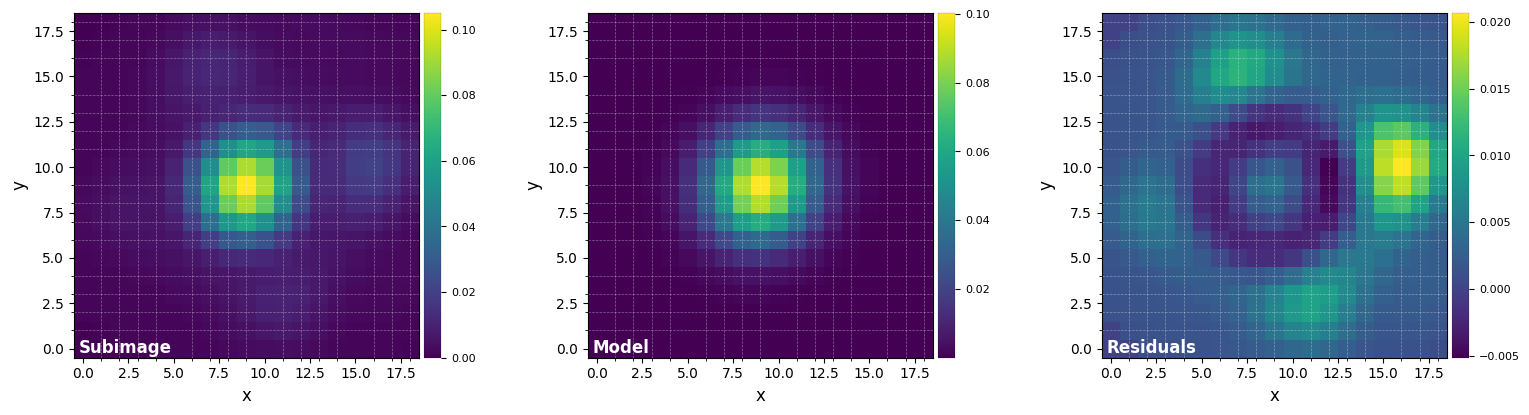

FWHM_y = 4.926059872957138
FWHM_x = 4.675778895005929 

centroid y = 9.010992107833063
centroid x = 9.01917912265807
centroid y subim = 9.010992107833063
centroid x subim = 9.01917912265807 

amplitude = 0.10032285220380603
theta = -38.446187060503874

Mean FWHM: 4.801
Flux in 1xFWHM aperture: 1.307


In [4]:
%matplotlib inline
from vip_hci.fm import normalize_psf
psfn, flux, fwhm_naco = normalize_psf(psf, size=19, debug=True, full_output=True)

In [5]:
print(fwhm_naco)

4.800919383981533


Let's visualize the flux-normalized PSF:

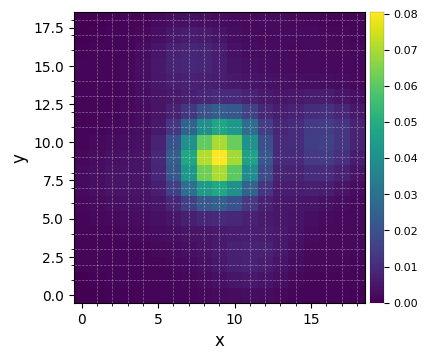

In [6]:
plot_frames(psfn, grid=True, size_factor=4)

Let's finally define the pixel scale for NACO (L' band), which we get from a dictionary stored in the `config` subpackage:

In [7]:
from vip_hci.config import VLT_NACO
pxscale_naco = VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


## 5.2. Generating and injecting synthetic planets

We first select an image library `imlib` for image operations (shifts, rotations) and associated `interpolation` order. 'vip-fft' is more accurate, but 'skimage' is faster, and 'opencv' even faster - see `Tutorial 7` for more details.

In [8]:
imlib_rot = 'skimage'       # If you have opencv installed, feel free to set this parameter to" 'opencv'
interpolation= 'biquintic'  # If you have opencv installed, feel free to set this parameter to 'lanczos4'
svd_mode = 'lapack'         # set it to 'arpack' if you have FORTRAN installed

The `cube_inject_companions` function in the `fm` module (VIP versions >= 1.1.0) makes the injection of fake companions at arbitrary fluxes and locations very easy. The normalized non-coronagraphic PSF should be provided for the injection. If the user does not have access to an observed PSF, the `create_synth_psf` from the `var` module can be used to create synthetic ones (based on 2D Gaussian, Moffat or Airy models).

Some procedures, e.g. the negative fake companion technique and the contrast curve generation, heavily rely on the injection of fake companions. The coordinates for the injection should be provided in the **derotated** image, while the actual injection occurs in the images of the input cube, i.e. in the *rotated* field.

In [9]:
rad_fc = 30.5
theta_fc = 240
flux_fc = 400.

gt = [rad_fc, theta_fc, flux_fc]

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="war1"></a>

The convention in VIP is to measure angles from positive x axis (i.e. as trigonometric angles), as in most other Python packages. This implies adding 90º to position angles measured following the common astronomic convention (East from North).
</div>

In [10]:
from vip_hci.fm import cube_inject_companions
cubefc = cube_inject_companions(cube, psf_template=psfn, angle_list=angs, flevel=flux_fc, plsc=pxscale_naco, 
                                rad_dists=[rad_fc], theta=theta_fc, n_branches=1, 
                                imlib=imlib_rot, interpolation=interpolation)


Let's set the corresponding cartesian coordinates:

In [11]:
from vip_hci.var import frame_center

cy, cx = frame_center(cube[0])
x_fc = cx + rad_fc*np.cos(np.deg2rad(theta_fc))
y_fc = cy + rad_fc*np.sin(np.deg2rad(theta_fc))

xy_test = (x_fc, y_fc)
print('({:.1f}, {:.1f})'.format(xy_test[0],xy_test[1]))

(34.7, 23.6)


Let's double-check the fake companion was injected at the right location, by post-processing the cube and checking the final image. Let's use PCA, and infer the optimal $n_{\rm pc}$ while we are at it - this will be useful for the next section.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-19 16:39:44
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.012166
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 41
Optimal number of PCs = 7, for S/N=11.105
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 34.7, 23.6
Flux in a centered 1xFWHM circular aperture = 146.645
Central pixel S/N = 13.443
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 11.105
Max S/N (shifting the aperture center) = 15.556
stddev S/N (shifting the aperture center) = 2.665



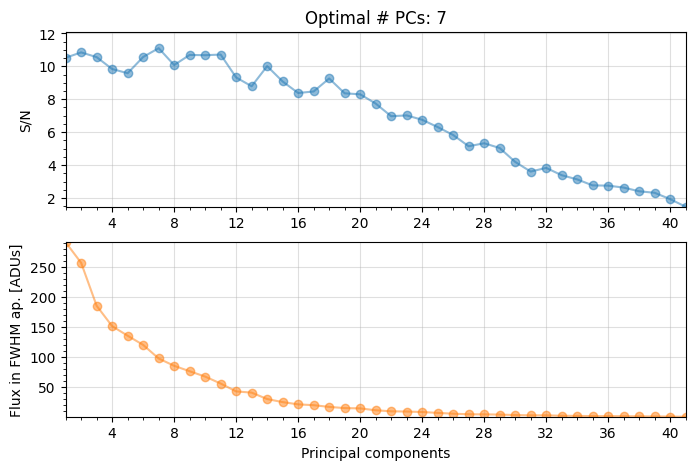

In [12]:
from vip_hci.psfsub import pca_grid
res_ann_opt = pca_grid(cubefc, angs, fwhm=fwhm_naco, range_pcs=(1,41,1), source_xy=xy_test, mode='annular',
                       annulus_width=4*fwhm_naco, imlib=imlib_rot, interpolation=interpolation, 
                       full_output=True, plot=True, svd_mode=svd_mode)

The grid search looking for the optimal number of principal components (npc) found that 10 principal components maximizes the S/N ratio of the injected fake companion. 

In [13]:
_, final_ann_opt, _, opt_npc_ann = res_ann_opt

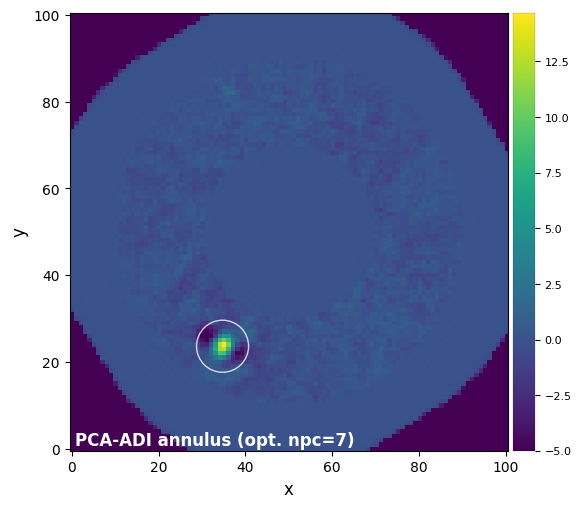

In [14]:
plot_frames(final_ann_opt, label='PCA-ADI annulus (opt. npc={:.0f})'.format(opt_npc_ann),
            dpi=100, vmin=-5, colorbar=True, circle=xy_test)

We can see that the fake companion was indeed injected at the requested location.

## 5.3. Flux and position estimation with NEGFC

When a companion candidate is detected, the next step is to characterize it, i.e. infer its exact position (astrometry) and flux (photometry). 

<font color=orange> **Question 5.1**: Why would a simple 2D Gaussian fit (as performed e.g. for the stellar PSF in Section 5.1) be inappropriate to extract the astrometry and photometry of a candidate companion? </font>

`VIP` implements the Negative fake companion (NEGFC) technique for robust extraction of the position and flux of detected point-like sources. The technique can be summarized as follow (see full description in [Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract)):

1) Estimate the position and flux of the planet, from either the visual inspection of reduced images or a previous estimator (see ABC below).

2) Scale (in flux) and shift the normalized off-axis PSF to remove the estimate from the input data cube.

3) Process the cube with PCA in a single annulus encompassing the point source.

4) Measure residuals in an aperture centered on the approximate location of the companion candidate.

5) Iterate on the position and flux of the injected negative PSF (steps 2-4), until the absolute residuals in the aperture are minimized (i.e. the injected negative companion flux and the position match exactly that of the true companion).

Iterations between steps 2-4 can be performed in one of 3 ways - sorted in increasing computation time and accuracy: 

A) a grid search on the flux only, provided a fixed estimate of the position (implemented in the `firstguess` function);

B) a Nelder-Mead simplex algorithm (`firstguess` function with the `simplex=True` option);

C) an MCMC sampler, which has the advantage to also yield uncertainties on each of the parameters of the point source (`mcmc_negfc_sampling` function).

Different figures of merit can be used for minimization of the residuals ([Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract); [Christiaens et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.6117C/abstract)):
$$\chi^2 = \sum_j^N \frac{(I_j-\mu)^2}{\sigma^2}~~({\rm default}), ~~~~~~~~\chi^2 = \sum_j^N |I_j|, ~~~~~~~~\chi^2 = N {\rm std}(I_j).$$

where $j \in {1,...,N}$, $N$ is the total number of pixels contained in the circular aperture around the companion candidate, $\mu$ and $\sigma$ are the mean and standard deviation ($N_{\rm resel}$ degrees of freedom) of pixel intensities in a truncated annulus at the radius of the companion candidate, but avoiding the azimuthal region encompassing the negative side lobes.

### 5.3.1. Nelder-Mead based optimization

With the function `firstguess`, we can obtain a first estimation of the flux and position by running A) a naive grid minimization (grid of values for the flux through parameter `f_range`), and B) a Nelder-mead based minimization (if the parameter `simplex` is set to *True*). The latter is done based on the preliminary guess of the grid minimization. The maximum number of iterations and error can be set with the parameter `simplex_options` as a dicitionary (see `scipy.minimize` function for the Nelder-Mead options).

Fisrt we define the position of the sources by examining a flux frame or S/N map. `planets_xy_coord` takes a list or array of X,Y pairs like ((x1,y1),(x2,y2)...(x_n,y_n)). Let's take the coordinates of the previously injected companion.

Let's test the algorithm with different values for the # of PCs: 5 and 25.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-19 16:42:42
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   1.564
2/30   0.149   1.564
3/30   0.221   1.563
4/30   0.329   1.563
5/30   0.489   1.562
6/30   0.728   1.560
7/30   1.083   1.557
8/30   1.610   1.554
9/30   2.395   1.548
10/30   3.562   1.540
11/30   5.298   1.528
12/30   7.880   1.510
13/30   11.721   1.484
14/30   17.433   1.445
15/30   25.929   1.388
16/30   38.566   1.307
17/30   57.362   1.192
18/30   85.317   1.018
19/30   126.896   0.790
20/30   188.739   0.504
21/30   280.722   0.210
22/30   417.532   0.061


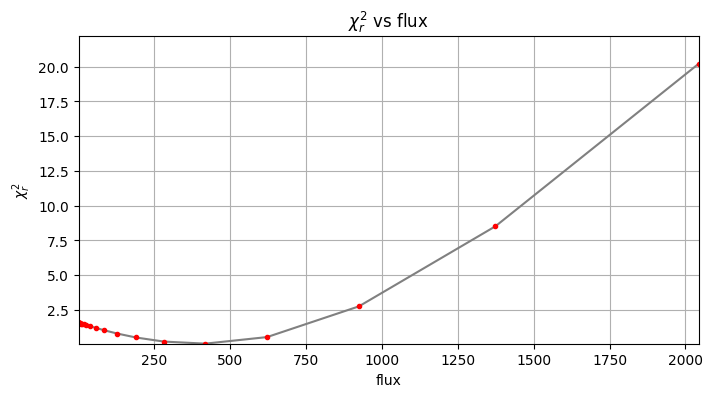

Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 417.53
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 107, nfev: 232, chi2r: 0.05597898104464966
message: Optimization terminated successfully.
Planet 0 simplex result: (r, theta, f)=(30.525, 240.121, 402.447) at 
          (X,Y)=(34.79, 23.53)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:49.297862
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [17]:
from vip_hci.fm import firstguess
r_lo, theta_lo, f_lo = firstguess(cubefc, angs, psfn, ncomp=5, planets_xy_coord=[xy_test], 
                                  fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                                  aperture_radius=2, simplex=True, imlib=imlib_rot, 
                                  interpolation=interpolation, algo_options={'svd_mode':svd_mode},
                                  plot=True, verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-19 16:43:31
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   0.228
2/30   0.149   0.228
3/30   0.221   0.228
4/30   0.329   0.228
5/30   0.489   0.228
6/30   0.728   0.228
7/30   1.083   0.228
8/30   1.610   0.228
9/30   2.395   0.227
10/30   3.562   0.227
11/30   5.298   0.227
12/30   7.880   0.225
13/30   11.721   0.223
14/30   17.433   0.221
15/30   25.929   0.222
16/30   38.566   0.218
17/30   57.362   0.209
18/30   85.317   0.186
19/30   126.896   0.154
20/30   188.739   0.128
21/30   280.722   0.082
22/30   417.532   0.058


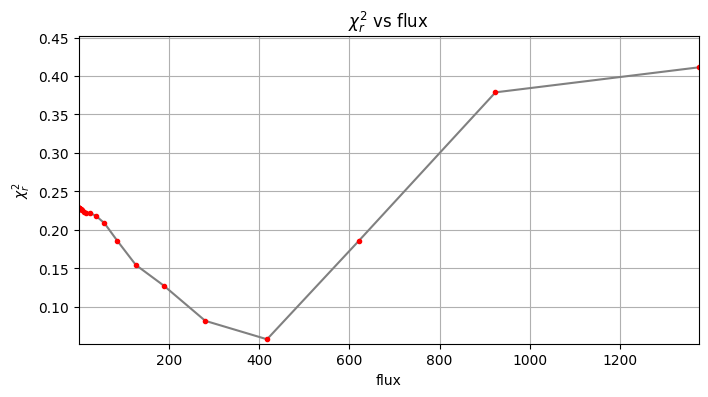

Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 417.53
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 118, nfev: 254, chi2r: 0.05405611443602665
message: Optimization terminated successfully.
Planet 0 simplex result: (r, theta, f)=(30.416, 239.946, 404.124) at 
          (X,Y)=(34.77, 23.67)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:52.946766
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [18]:
r_hi, theta_hi, f_hi = firstguess(cubefc, angs, psfn, ncomp=25, planets_xy_coord=[xy_test], 
                                  fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                                  aperture_radius=2, imlib=imlib_rot, interpolation=interpolation, 
                                  algo_options={'svd_mode':svd_mode},simplex=True, plot=True, verbose=True)

For both the $n_{\rm pc} = 5$ and $n_{\rm pc} = 25$ cases, the parameters estimated by the Nelder-Mead optimization are not exactly equal to the original values (radius=30.5, theta=240, flux=400), which reflects:

- the limitations of this heuristic minization procedure (depending on the initial guess the minimization may get trapped in a different local minimum);
- the higher residual speckle noise level in images obtained with low $n_{\rm pc}$ values; 
- the higher self-subtraction for high $n_{\rm pc}$ values.

These estimates are provided without uncertainties (error bars). We will come back to this question later on. 

For comparison, let's use the optimal $n_{\rm pc} = 10$ found in [Section 5.2](#5.2.-Generating-and-injecting-synthetic-planets):

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-19 16:44:24
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   2.226
2/30   0.149   2.225
3/30   0.221   2.224
4/30   0.329   2.223
5/30   0.489   2.222
6/30   0.728   2.219
7/30   1.083   2.215
8/30   1.610   2.210
9/30   2.395   2.202
10/30   3.562   2.190
11/30   5.298   2.173
12/30   7.880   2.148
13/30   11.721   2.110
14/30   17.433   2.055
15/30   25.929   1.978
16/30   38.566   1.867
17/30   57.362   1.694
18/30   85.317   1.461
19/30   126.896   1.147
20/30   188.739   0.716
21/30   280.722   0.274
22/30   417.532   0.062


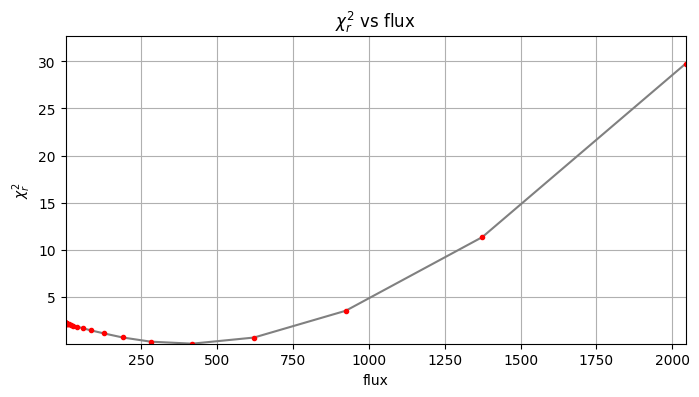

Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 417.53
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 97, nfev: 212, chi2r: 0.0590741891894191
message: Optimization terminated successfully.
Planet 0 simplex result: (r, theta, f)=(30.477, 240.031, 403.264) at 
          (X,Y)=(34.78, 23.60)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:44.941360
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [19]:
r_0, theta_0, f_0 = firstguess(cubefc, angs, psfn, ncomp=opt_npc_ann, planets_xy_coord=[xy_test], 
                               fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                               aperture_radius=2, imlib=imlib_rot, interpolation=interpolation, 
                               algo_options={'svd_mode':svd_mode},simplex=True, plot=True, verbose=True)

We see that using the optimal $n_{\rm pc}$ leads to closer parameter estimates to the ground truth.

<font color=green> **Answer 5.1**: If relying on a 2D Gaussian fit, both the photometry and astrometry would be biased by self-subtraction and the negative side lobes. </font>

### 5.3.2. Planet subtraction

Let's use the values obtained with the simplex optimization to subtract the planet with the function `cube_planet_free`.

First we define a list with the parameters (r, theta, flux) is each companion that we obtained via the NegFC, in this case one:

In [20]:
plpar_fc = [(r_0[0], theta_0[0], f_0[0])]

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="war1"></a>

r_0, theta_0 and f_0 have the same length as the number of planet coordinates `planets_xy_coord` provided to `firstguess`. Here there is only one planet, so we take the zeroth index. The number of tuples in `plpar_fc` should match the number of planets.
</div>

In [21]:
from vip_hci.fm import cube_planet_free
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, imlib=imlib_rot, interpolation=interpolation)

Let's double-check the fake companion was well removed by computing a PCA post-processed image:

In [22]:
from vip_hci.psfsub import pca_annulus
fr_pca_emp = pca_annulus(cube_emp, angs, ncomp=opt_npc_ann, annulus_width=4*fwhm_naco, 
                         r_guess=rad_fc, imlib=imlib_rot, interpolation=interpolation,
                         svd_mode=svd_mode)


Let's take a look at the PSF of the planet in the full-frame PCA final image and the same PSF in the frame resulting of processing the planet-subtracted cube:

In [23]:
from vip_hci.preproc import frame_crop
cropped_frame1 = frame_crop(final_ann_opt, 15, xy_test)

New shape: (15, 15)


In [24]:
cropped_frame2 = frame_crop(fr_pca_emp, 15, xy_test)

New shape: (15, 15)


Let's use both `'mode=surface'` and the default image mode of `plot_frames` to show the residuals in the vicinity of the companion:

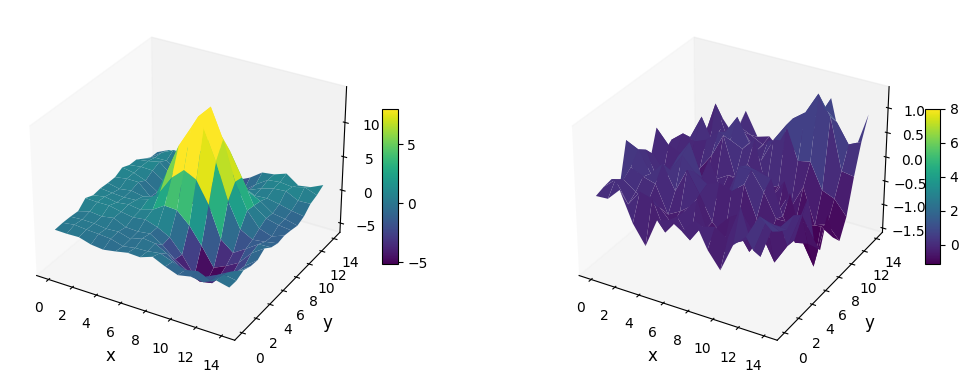

In [25]:
plot_frames((cropped_frame1, cropped_frame2), mode='surface', vmax=8)

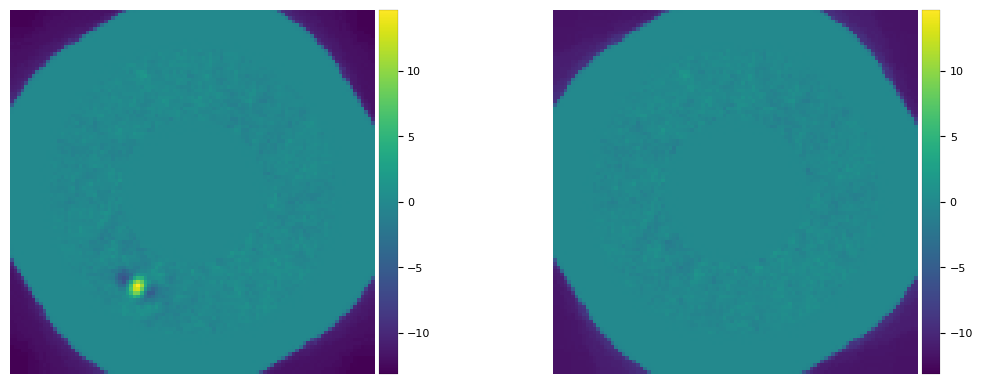

In [26]:
plot_frames((final_ann_opt, fr_pca_emp), vmin = float(np.amin(final_ann_opt)), 
            vmax= float(np.amax(final_ann_opt)), axis=False)

Not only the bright point-like signal is subtracted, but so are the negative side lobes. A subtraction not leaving any significant artifact/defect is a good sign that the inferred parameters are correct. However, keep in mind that even for slightly inaccurate parameters, the final image can still look relatively clean. Let's take for example the parameters inferred with non-optimal $n_{\rm pc}$: 

[(30.52487741552916, 240.12125437412487, 402.4474352276101)]


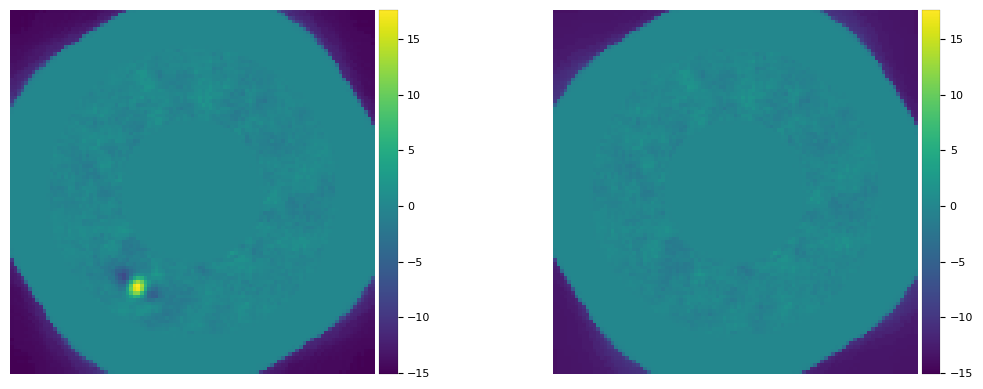

In [27]:
# planet parameters inferred from npc=5 used to make empty cube, then processed with PCA (npc=10)
plpar_fc = [(r_lo[0], theta_lo[0], f_lo[0])]
print(plpar_fc)
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, imlib=imlib_rot, interpolation=interpolation)
final_ann_5 = pca_annulus(cubefc, angs, ncomp=5, annulus_width=4*fwhm_naco, r_guess=30.5,
                          imlib=imlib_rot, interpolation=interpolation,
                          svd_mode=svd_mode)
fr_pca_emp5 = pca_annulus(cube_emp, angs, ncomp=5, annulus_width=4*fwhm_naco, r_guess=30.5,
                          imlib=imlib_rot, interpolation=interpolation,
                          svd_mode=svd_mode)
plot_frames((final_ann_5, fr_pca_emp5), vmin = float(np.amin(final_ann_5)), 
            vmax= float(np.amax(final_ann_5)), axis=False)

[(30.415502356073276, 239.94572901405076, 404.1240116815397)]


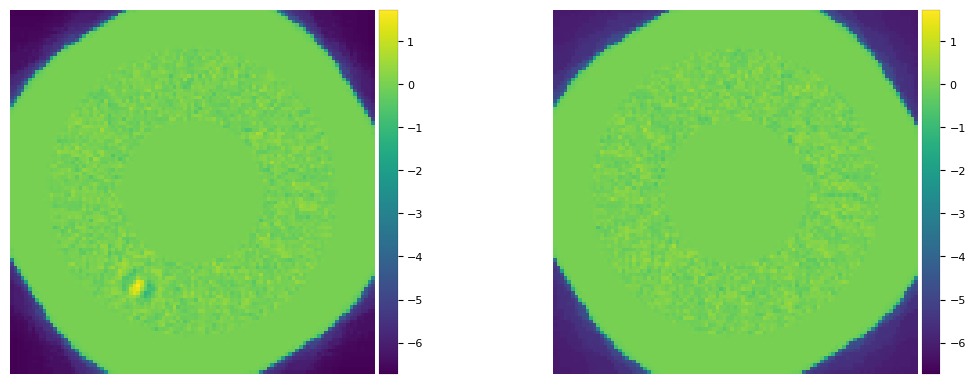

In [28]:
# parameters inferred from npc=25 used to make empty cube, then processed with PCA (npc=10)
plpar_fc = [(r_hi[0], theta_hi[0], f_hi[0])]
print(plpar_fc)
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, imlib=imlib_rot, interpolation=interpolation)
final_ann_25 = pca_annulus(cubefc, angs, ncomp=25, annulus_width=4*fwhm_naco, r_guess=30.5,
                           imlib=imlib_rot, interpolation=interpolation,
                           svd_mode=svd_mode)
fr_pca_emp25 = pca_annulus(cube_emp, angs, ncomp=25, annulus_width=4*fwhm_naco, r_guess=30.5,
                           imlib=imlib_rot, interpolation=interpolation,
                           svd_mode=svd_mode)
plot_frames((final_ann_25, fr_pca_emp25), vmin = float(np.amin(final_ann_25)), 
            vmax= float(np.amax(final_ann_25)), axis=False)

Inaccurate parameters still leading to an apparently good removal of the companion brings the question of the uncertainties on each of the three parameters characterizing the companion. The next sections are dedicated to this question. 

### 5.3.3. NEGFC technique coupled with MCMC

#### 5.3.3.1. Running the MCMC sampler

Markov Chain Monte Carlo (MCMC) is a robust way of obtaining the flux and position of the companion, and their uncertainties. 
MCMC samples the parameter space (here r and $\theta$ coordinates, and flux) using a number of *walkers* following a Markov chain (i.e. a process where each new sampled point only depends on the previous one) for a certain number of iterations.
At each iteration, a new sample of parameters is proposed to each walker to explore the parameter space (these are called *moves*), based on a given *proposal function* (e.g., the *stretch* move proposed in Goodman & Weare 2010). A criterion depending on the ratio of likelihoods calculated for the proposed vs the current parameters is then used to accept or reject the proposed moves for the next iteration (if rejected, the parameters do not change).

In our case the log-likelihood is calculated assuming that a perfect subtraction of the companion leads to pixel intensity residuals following a Gaussian distribution (centered on zero, and scaled by the standard deviation estimated in the annulus except in the area of the companion). A convergence criterion based on *autocorrelation* can be used (and is used by default in VIP) to stop iterating.
Sampling the final posterior distributions of the parameters yields both the most likely parameter values and uncertainties on each of them. 

The MCMC implementation in VIP leverages [`emcee`](https://emcee.readthedocs.io/en/stable/) ([Foreman-Mackey et al. 2013](https://ui.adsabs.harvard.edu/abs/2013PASP..125..306F/abstract); check the paper for more details on this implementation of MCMC), which is based on an efficient affine-invariant implementation of MCMC proposed in Goodman & Weare (2010).
The relevant function is `mcmc_negfc_sampling`, which can accept a number of parameters. Let's define them in the next few boxes:

Let's first define observation-related parameters, such as the non-coronagraphic psf, its FWHM and the pixel scale od the detector: 

In [29]:
obs_params = {'psfn': psfn,
              'fwhm': fwhm_naco}

In NEGFC, PCA in a single annulus is used by default to speed up the algorithm - although other algorithms can be used through the `algo` parameter. Let's set the $n_{\rm pc}$ to the optimal $n_{\rm pc}$ found in [Section 5.2](#5.2.-Generating-and-injecting-synthetic-planets). We set the width of the annulus on which PCA is performed (in pixels) with the `annulus_width` parameter. We also set a few other algorithm-related parameters in the following box:

In [30]:
annulus_width = 4*fwhm_naco

algo_params = {'algo': pca_annulus,
               'ncomp': opt_npc_ann,
               'annulus_width': annulus_width,
               'svd_mode': svd_mode,
               'imlib': imlib_rot, 
               'interpolation': interpolation}

The choice of log-likelihood expression to be used is determined by `mu_sigma` and `fmerit`. If the former is True (default; mu and sigma calculated automatically) or a tuple of 2 values provided manually (corresponding to mean and standard deviation of pixel intensities in an annulus encompassing the companion), the following figure of merit will be used: $\chi^2 = \sum_j^N \frac{(I_j-\mu)^2}{\sigma^2}$ (as introduced in [Christiaens et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.6117C/abstract). Otherwise, the choice will be determined by `fmerit`:
- 'sum' for the sum of absolute residuals (details in [Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract));
- 'stddev' for the standard deviation of residuals (details in Wertz et al. 2017; which can be useful for very faint sources);
- 'hessian' for the determinant of the local Hessian matrix (which containes 2nd order derivatives with respect to spatial coordinates) - the latter being useful when the point source is contained within a more extended signal (see e.g. [Christiaens et al. 2024](https://ui.adsabs.harvard.edu/abs/2024arXiv240304855C/abstract)).
  
Another parameter to set is `aperture_radius`, which is the radius of the aperture  (in `fwhm` units) in which the residual intensities $I_j$ are considered.

In [31]:
mu_sigma=True
aperture_radius=2

negfc_params = {'mu_sigma': mu_sigma,
                'aperture_radius': aperture_radius}

Parameter ``initial_state`` corresponds to the initial first estimation of the planets parameters (r, theta, flux). We set it to the result of the simplex optimization, obtained with optimal $n_{\rm pc}$.

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="war1"></a>

The MCMC minimization can only run for one companion candidate at a time, hence the first dimension of init should always be 3 (not the number of planets, as opposed to `planets_xy_coord` in `firstguess`).
</div>

In [32]:
initial_state = np.array([r_0[0], theta_0[0], f_0[0]])

Beware that the MCMC procedure is a CPU intensive procedure and can take several hours when run properly on a standard laptop. We use the affine invariant sampler from `emcee` which can be run in parallel (`nproc` sets the number of CPUs to be used). At least 100 walkers are recommended for our MCMC chain, although both the number of walkers and iterations will depend on your dataset. 
For the sake of preventing this tutorial to take too long to run, we set the maximum number of iterations to 500, although feel free to significantly increase it in case of non-convergence.

In [33]:
from multiprocessing import cpu_count

nwalkers, itermin, itermax = (100, 200, 500)

mcmc_params = {'nwalkers': nwalkers,
               'niteration_min': itermin,
               'niteration_limit': itermax,
               'bounds': None,
               'nproc': cpu_count()//2}


Another update from Christiaens et al. (2021) is that the convergence can now be evaluated based on the auto-correlation time (see more details in the [documentation of `emcee`](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/)), instead of the Gelman-Rubin test, which is inappropriate for non-independent samples (such as an MCMC chain).
We set the convergence test to the autocorrelation time based criterion using `conv_test='ac'` (instead of Gelman-Rubin 'gb'). We also set the autocorrelation criterion $N/\tau >= a_c$, where $N$ is the number of samples and $\tau$ the autocorrelation time, to `ac_c=50` (the value recommended in the `emcee` documentation). Finally, we set the number of consecutive times the criterion must be met to: `ac_count_thr=1`, and the maximum gap in number of steps between 2 checks of the convergence criterion to: `check_maxgap=50`. If the maximum number of iterations `niteration_limit` is large enough, the chain will stop upon meeting the convergence criterion (spoiler: it won't be the case here since we chose a small value for `niteration_limit`).

In [34]:
conv_test, ac_c, ac_count_thr, check_maxgap = ('ac', 50, 1, 50)

conv_params = {'conv_test': conv_test,
               'ac_c': ac_c,
               'ac_count_thr': ac_count_thr,
               'check_maxgap': check_maxgap}

Setting `bounds=None` does *not* mean no bounds are used for parameter exploration, but rather that they are set automatically to:

- $r \in [r_0-w_{ann}/2, r_0+w_{ann}/2]$, where $w_{ann}$ is the `annulus_width`,
- $\theta \in [\theta_0-\Delta {\rm rot}, \theta_0+\Delta {\rm rot}]$, where $\Delta {\rm rot}$ is the angle subtended by min(`aperture_radius`/2,`fwhm`) at $r_0$,
- $f \in [0.1*f_0, 2*f_0]$,

where ($r_0, \theta_0, f_0$) = `initial_state`.
If the `bounds` are provided manually (as a tuple of tuples), they will supersede the automatic setting above.

Now let's start the sampler. Note that this step is computer intensive and may take a long time to run depending on your machine. Feel free to skip the next cell if you do not wish to run the MCMC or can't run it in a reasonable time. The results are already saved as 'MCMC_results' in the 'datasets' folder and will be loaded in the subsequent boxes.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-05 14:56:42
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
        MCMC sampler for the NEGFC technique       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
The mean and stddev in the annulus at the radius of the companion (excluding the PA area directly adjacent to it) are -0.11 and 1.91 respectively.
Beginning emcee Ensemble sampler...
emcee Ensemble sampler successful

Start of the MCMC run ...
Step  |  Duration/step (sec)  |  Remaining Estimated Time (sec)
0		5.38452			2686.87548
1		4.59892			2290.26017
2		4.56100			2266.81750
3		4.55227			2257.92642
4		4.85771			2404.56398
5		4.63168			2288.04943
6		4.86092			2396.43307
7		4.76470			2344.23338
8		4.69724			2306.34582
9		4.81512			2359.41027
10		4.98254			2436.46059
11		4.75354			2319.72557
12		4.91667			2394.41926
13		4.69853			2283.48704
14		4.57682			2219.755

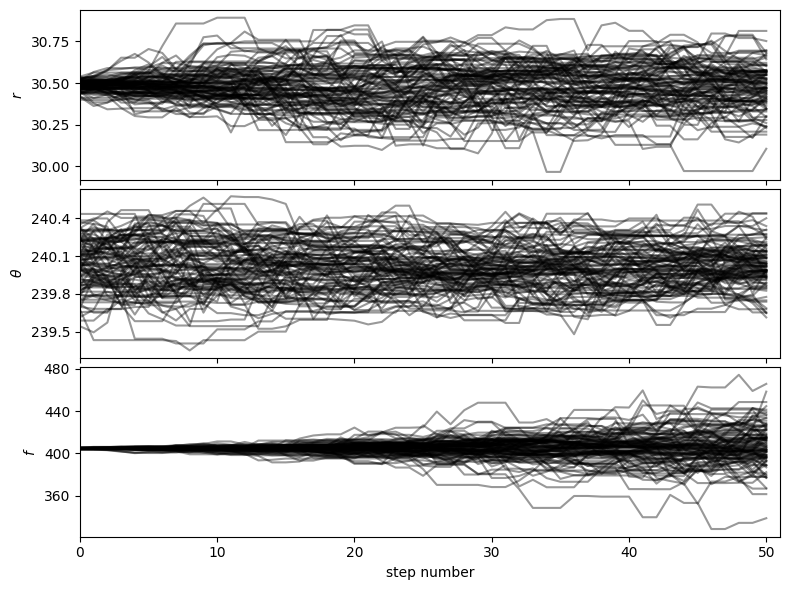

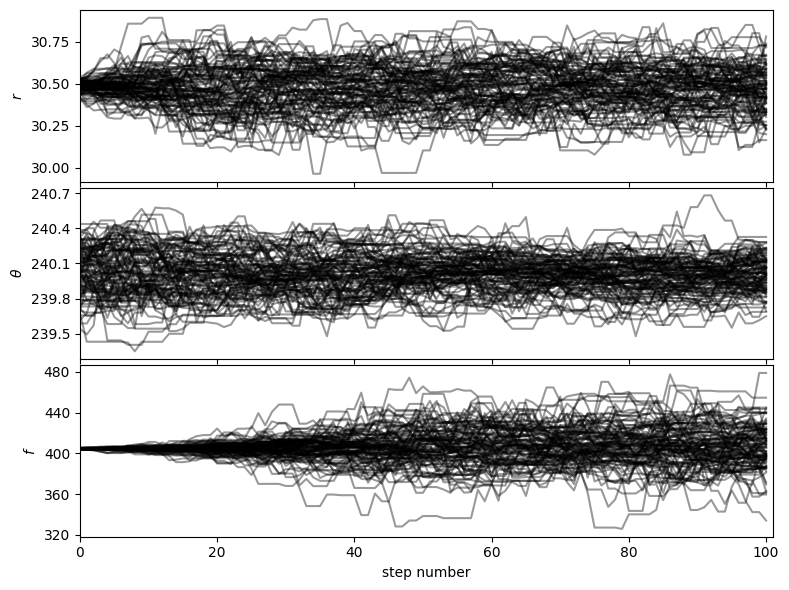

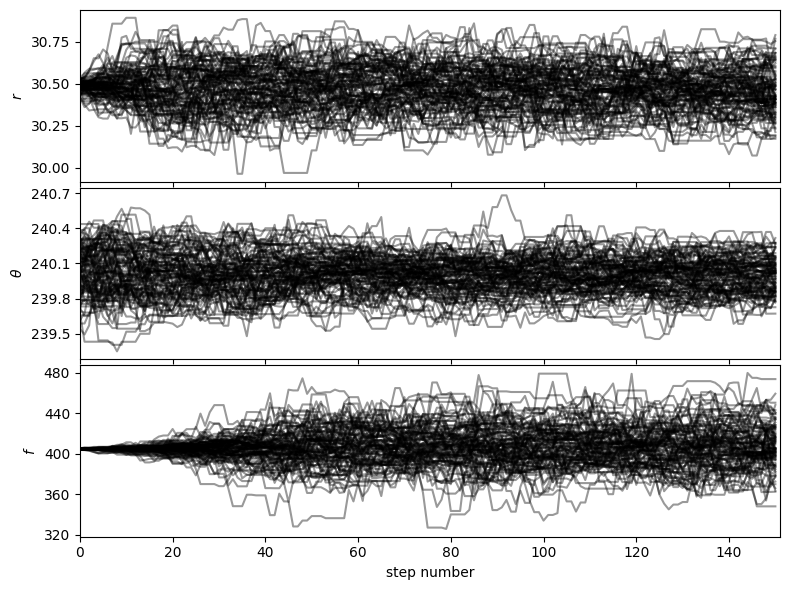

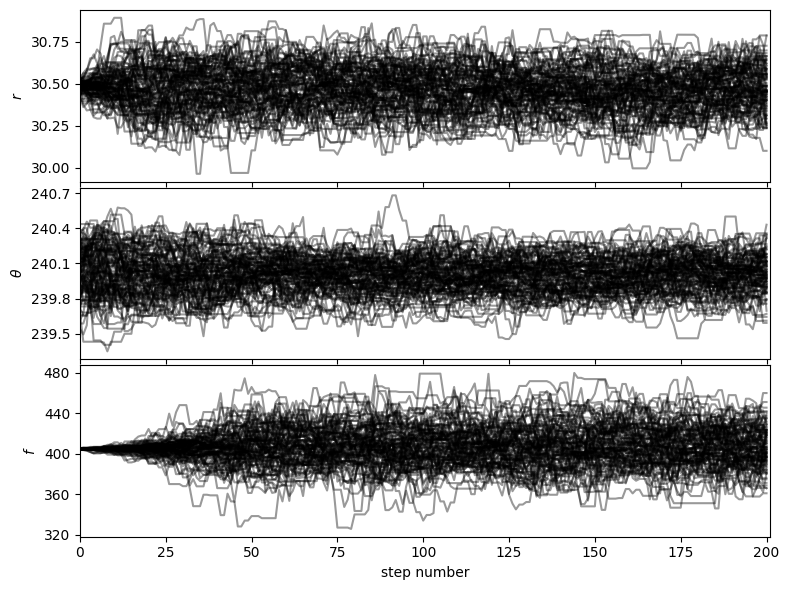

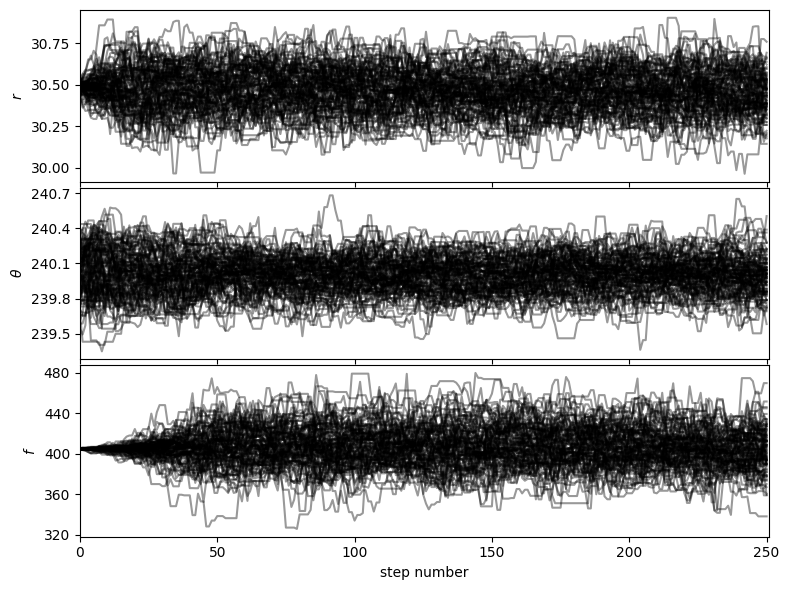

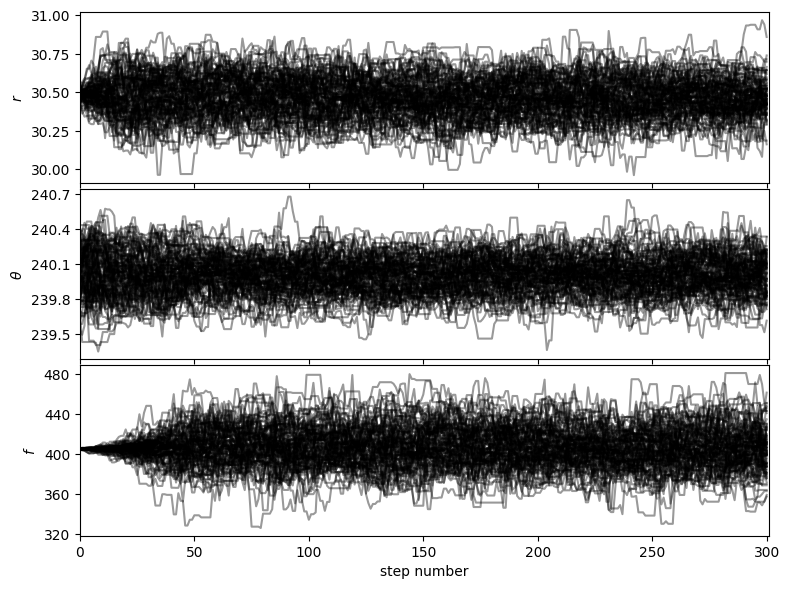

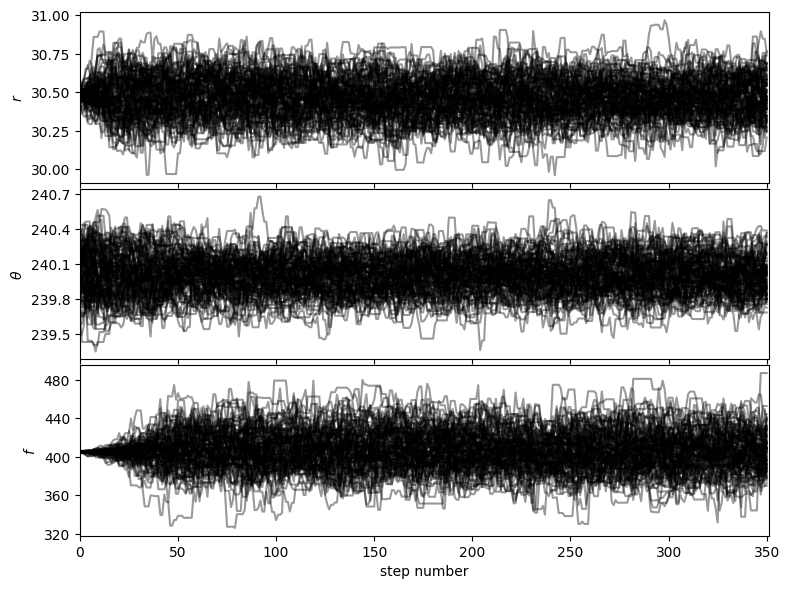

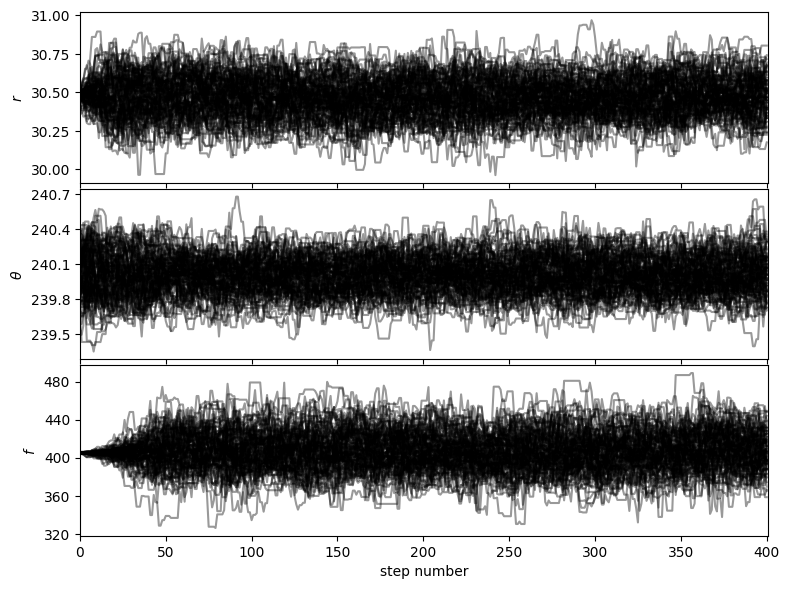

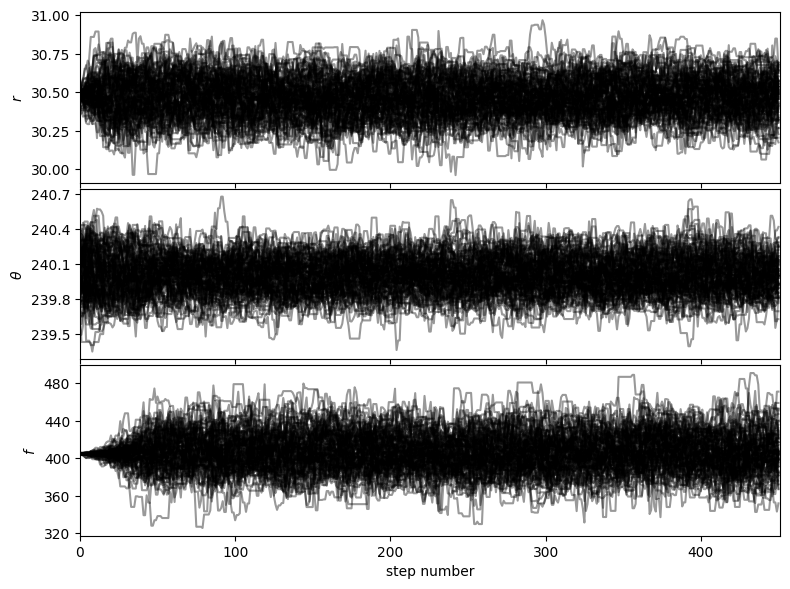

In [33]:
from vip_hci.fm import mcmc_negfc_sampling
chain = mcmc_negfc_sampling(cubefc, angs, **obs_params, **algo_params, **negfc_params, 
                            initial_state=initial_state, **mcmc_params, **conv_params,
                            display=True, verbosity=2, save=False, output_dir='./')

If you ran the previous box and wish to write your results, set `write=True` in the next box. This will pickle the MCMC chain.

In [34]:
write=False

if write:
    import pickle
    output = {'chain':chain}
    with open('../datasets/my_MCMC_results', 'wb') as fileSave:
        pickle.dump(output, fileSave)

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="war1"></a>

An alternative to the cell above, is to provide `output_dir` in the call to `mcmc_negfc_sampling` and set `save` to True. This will save the results as a pickle including additional keys: apart from 'chain', it will also save 'input_parameters', 'AR' (acceptance ratio), and 'lnprobability'.

</div>

Pickled results can be loaded from disk like this:

In [35]:
import pickle
with open('../datasets/MCMC_results','rb') as fi:
    myPickler = pickle.Unpickler(fi)
    mcmc_result = myPickler.load()

print(mcmc_result.keys())
chain = mcmc_result['chain']

dict_keys(['chain', 'input_parameters', 'AR', 'lnprobability'])


The most accurate approach would involve setting a large enough maximum number of iterations and using FFT-based rotation for PCA. The latter in particular, may change a bit the most likely parameter values given the better flux conservation. However, these changes would involve over ~3 orders of magnitude longer calculation time. It is therefore intractable for a personal laptop and not shown in this notebook. If you have access to a supercomputer feel free to adopt these changes though. The results after 500 iterations are nonetheless good enough for illustrative purpose:

#### 5.3.3.2. Visualizing the MCMC chain: corner plots and walk plots 

Let's first check that the walk plots look ok:

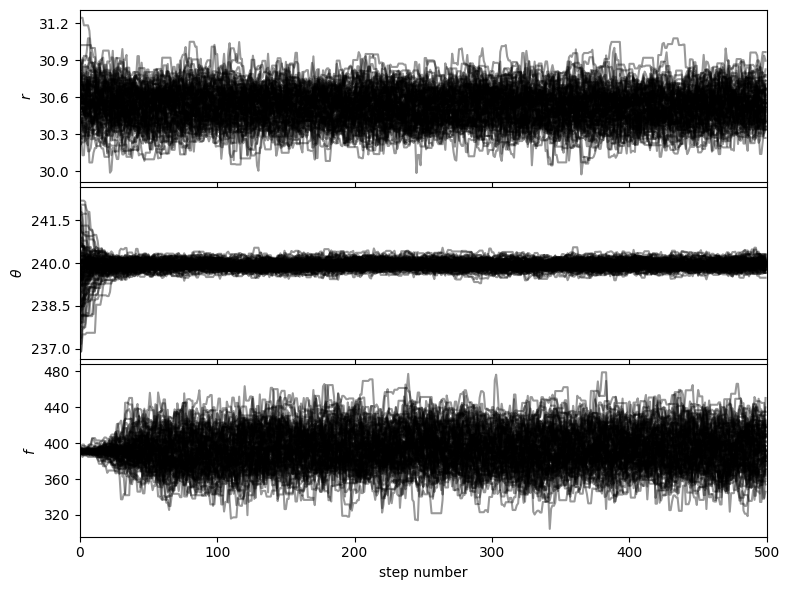

In [36]:
from vip_hci.fm import show_walk_plot
show_walk_plot(chain)

Then based on the walk plot, let's burn-in the first 30% of the chain (to only keep the iterations where the walkers appear to have mostly converged), to calculate the corner plots:

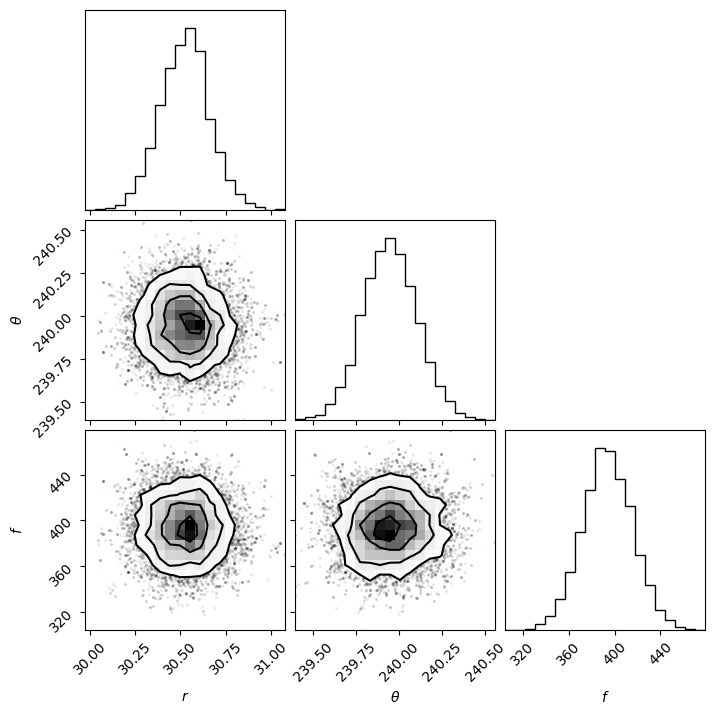

In [37]:
from vip_hci.fm import show_corner_plot
burnin = 0.3
burned_chain = chain[:, int(chain.shape[1]//(1/burnin)):, :]
show_corner_plot(burned_chain)

For the purpose of this tutorial and to limit computation time we set the maximum number of iterations to 500 for 100 walkers. The look of the corner plots may improve with more samples (i.e. higher number of iterations, for a given burn-in ratio). This can be tested by setting the max. number of iterations arbitrarily high for the autocorrelation-time convergence criterion to be met.

#### 5.3.3.3. Highly probable values and confidence intervals 

Now let's determine the most highly probable value for each model parameter, as well as the 1-sigma confidence interval. For this, let's first flatten the chains:

In [38]:
isamples_flat = chain[:, int(chain.shape[1]//(1/burnin)):, :].reshape((-1,3))

Then use the `confidence` function:

percentage for r: 69.79202279202278%
percentage for theta: 69.02279202279202%
percentage for f: 68.94017094017094%


Confidence intervals:
r: 30.57489764243517 [-0.20421878422770945,0.08279139901123145]
theta: 239.91771004343246 [-0.14527599962792692,0.18317408648738365]
f: 390.7650582608513 [-20.054061636888093,25.285555976945886]


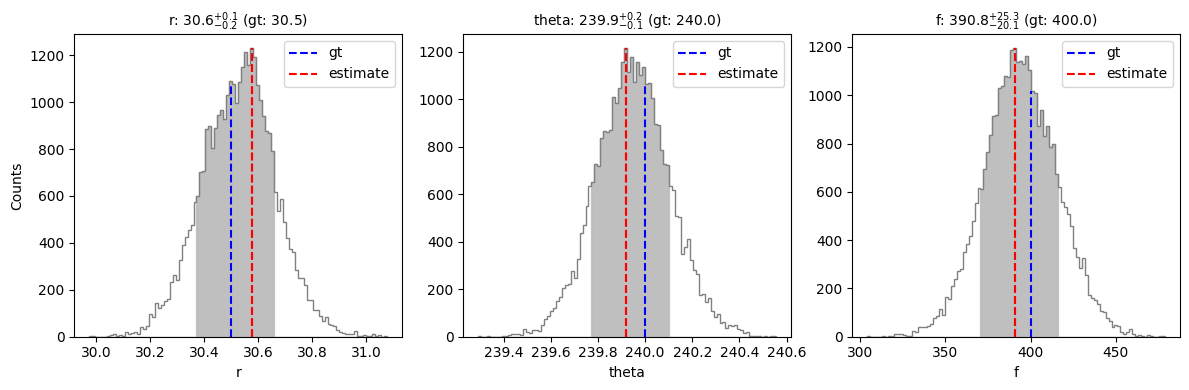

In [39]:
from vip_hci.fm import confidence
val_max, conf = confidence(isamples_flat, cfd=68, gaussian_fit=False, verbose=True, save=False, 
                           gt=gt, ndig=1, title=True)

Using the `confidence` function with the `gaussian_fit=True` option, it is possible to fit a Gaussian to the posterior distribution of each parameter, and infer associated uncertainty values.

percentage for r: 69.79202279202278%
percentage for theta: 69.02279202279202%
percentage for f: 68.94017094017094%


Confidence intervals:
r: 30.57489764243517 [-0.20421878422770945,0.08279139901123145]
theta: 239.91771004343246 [-0.14527599962792692,0.18317408648738365]
f: 390.7650582608513 [-20.054061636888093,25.285555976945886]

Gaussian fit results:
r: 30.525747462344565 +-0.13676103149725966
theta: 239.94793373875024 +-0.15744912409220196
f: 394.1338634773366 +-21.669634439677626


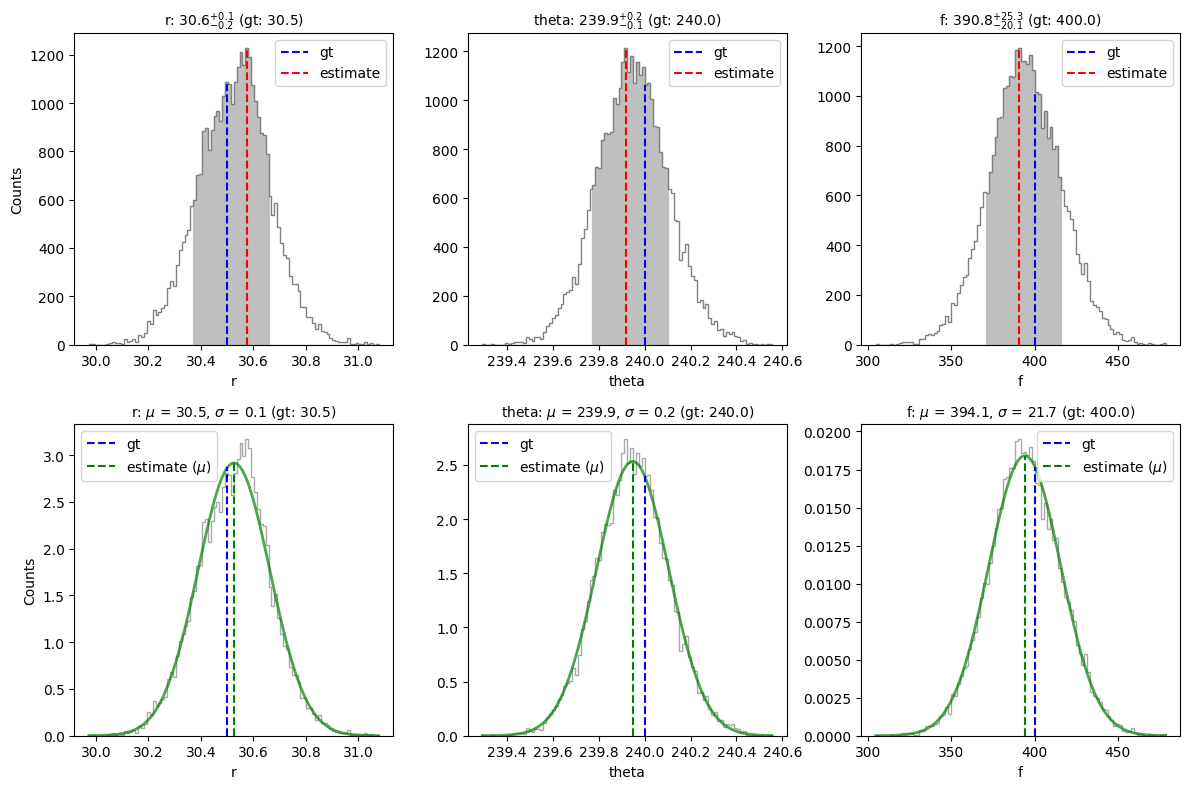

In [40]:
mu, sigma = confidence(isamples_flat, cfd=68, gaussian_fit=True, verbose=True, save=False, 
                       gt=gt, ndig=1, title=True)

It is recommended to report the results as confidence intervals (i.e. with possibly asymmetric uncertainties) as long as the bin interval is small enough. Here, we also fitted the residual posterior distribution of each parameter to a Gaussian distribution (this shape is the expected one if the noise has been well whitened, but is not necessarily guaranteed at all separations depending on the adopted $n_{\rm pc}$). In case these distributions look Gaussian, the inferred $\sigma$ value may be a more accurate uncertainty value for the different parameters.

We can see that the confidence intervals inferred by NEGFC for the different parameters encompass the ground truth values used for injection (in particular for the flux). 

<div class="alert alert-block alert-warning"> 
    <b>Warning: </b>
<a class="anchor" id="war1"></a>

Depending on your choice of `mu_sigma`, you may have to calculate separately another source of uncertainty. Indeed, with the original expression for $\chi^2$ (Wertz et al. 2017; `mu_sigma=False`), only the uncertainty associated to *photon noise* was reflected in the MCMC results. With the new expression (`mu_sigma=True`), the $\chi^2$ expression also takes into account the *residual speckle noise* at the radial separation of the companion candidate (at least if `sigma='spe+pho'` in the call, which is the default). Our tests on this dataset suggest that similar final uncertainties can be obtained in either of these 2 ways:  

- the uncertainties obtained with MCMC when setting `mu_sigma=True` and `sigma='spe+pho'`;  
- the uncertainties obtained by combining quadratically the uncertainties obtained with MCMC (setting `mu_sigma=False` and `fmerit = 'sum'`), and the residual speckle uncertainties inferred as in [Sec. 5.3.5](#5.3.5.-Residual-speckle-uncertainty) (Wertz et al. 2017).  
</div>

### 5.3.4. NEGFC technique coupled with nested sampling

Nested sampling can be a faster approach to estimate the optimal parameters, given a good first guess estimate.

The implementation in VIP relies on ``nestle`` ([Barbary 2013](https://github.com/kbarbary/nestle); more details [here](http://kylebarbary.com/nestle/)).

The procedure is essentially the same as for the MCMC sampler. Let's first set the parameters associated with the observation:

In [41]:
obs_params = {'psfn': psfn,
              'fwhm': fwhm_naco}

Let's then set the parameters associated with ``pca_annulus``, the PSF modeling and subtraction algorithm:

In [42]:
annulus_width = 4*fwhm_naco

algo_params = {'algo': pca_annulus,
               'ncomp': opt_npc_ann,
               'annulus_width': annulus_width,
               'svd_mode': svd_mode}
algo_options = {'imlib': imlib_rot, 
                'interpolation': interpolation}

For a change, let's consider `fmerit='sum'` for the choice of log-likelihood expression, hence set `mu_sigma=False`. Let's keep an `aperture_radius` of 2 FWHM.

In [43]:
aperture_radius=2
mu_sigma = False
fmerit = 'sum'

negfc_params = {'mu_sigma': mu_sigma,
                'fmerit': fmerit,
                'aperture_radius': aperture_radius}

Let's define our first guess on the parameters as the ``initial_state``:

In [44]:
initial_state = np.array([r_0[0], theta_0[0], f_0[0]])

Let's now define the parameters of the nested sampling algorithm. These are a bit different from MCMC:

- `npoints` sets the number of live points (similar to walkers in MCMC);
- `dlogz` is related to a criterion used to stop the iterations. Iterations will stop when the estimated contribution of the remaining prior volume to the total evidence falls below this threshold. Explicitly, the stopping criterion is log($z$ + $z_{\rm est}$) - log($z$) < $dlogz$ where $z$ is the current evidence from all saved samples, and $z_{\rm est}$ is the estimated contribution from the remaining volume. Typical good values: 0.1 or 0.5;
- `decline_factor` is related to an alternative criterion to stop the iterations. Iterations will stop when the weight (likelihood times prior volume) of newly saved samples has been declining for decline_factor * nsamples consecutive samples. A value of 1.0 yields good results on this dataset.
- `w` are the windows that will bound the exploration space for each parameter. These should be provided in the respective units of each input parameter.
- `rstate` can be used to specify a given random state to start with.

In [45]:
npoints = 100
dlogz, decline_factor = (0.1, None)
rstate = None
w = (5, 5, 200)

nested_params = {'npoints': nwalkers,
                 'dlogz': dlogz,
                 'decline_factor': None,
                 'rstate': rstate,
                 'w': w}

Now let's start the sampler. Note that this step is computer intensive and may take a few minutes to run depending on your machine (but typically goes 4-5x faster than MCMC with 500 iterations considering the aboved parameters).

In [46]:
from vip_hci.fm import nested_negfc_sampling
nested_res = nested_negfc_sampling(initial_state, cubefc, angs, **obs_params, **algo_params, algo_options=algo_options,
                                   **negfc_params, **nested_params, verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-05 15:36:17
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Prior bounds on parameters:
Radius [25.48510847427911,35.48510847427911]
Theta [235.03055781801652,245.03055781801652]
Flux [204.54399679829373,604.5439967982937]

Using 100 active points

Total running time:
Running time:  0:08:36.916331
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


The results of the nested sampling as stored in a nestle object. The results can be conveniently inferred using the aptly named `nested_sampling_results` function, which can also write the results (through `save` and `output_dir` arguments):

niter: 1339
ncall: 2780
nsamples: 1439
logz: -62.092 +/-  0.300
h:  8.977

Natural log of prior volume and Weight corresponding to each sample


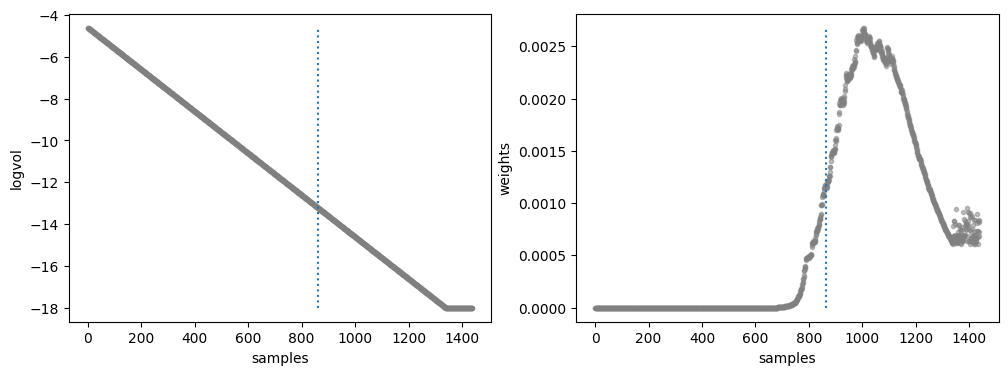


Walk plots before the burnin

Walk plots after the burnin


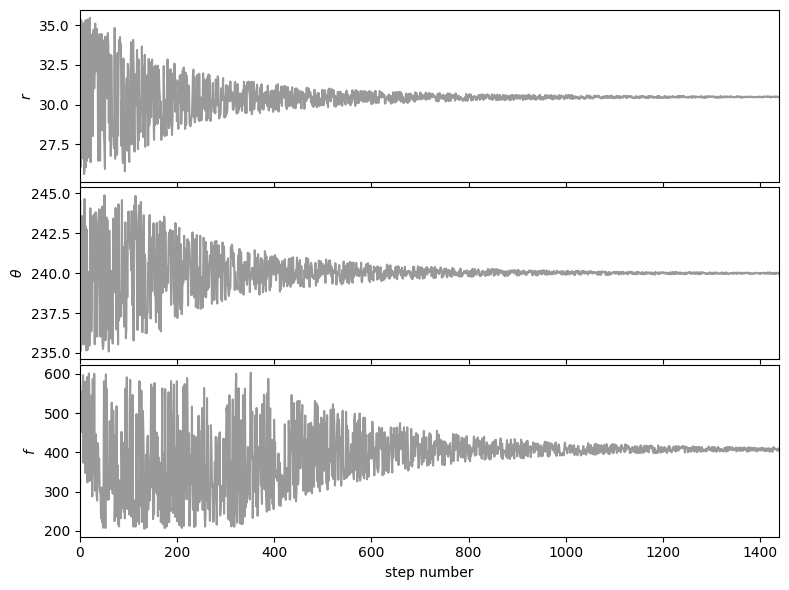

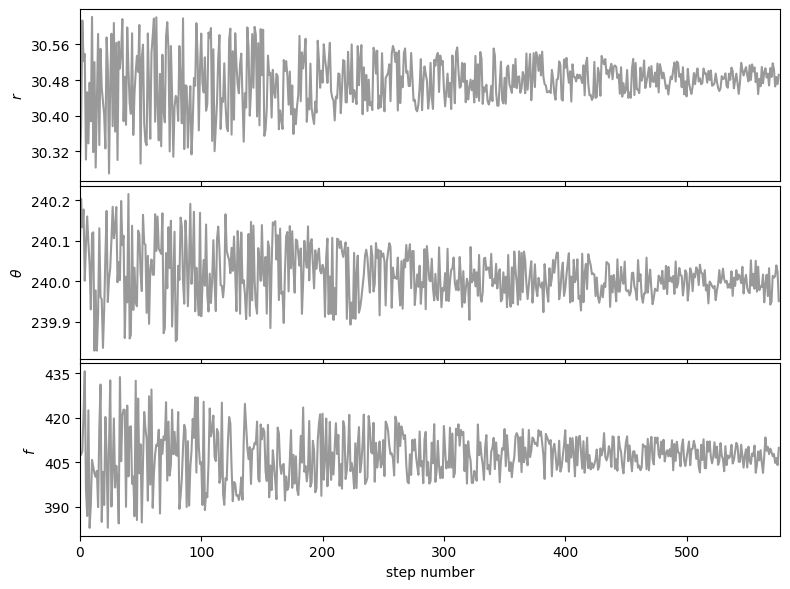


Weighted mean +- sqrt(covariance)
Radius = 30.474 +/- 0.066
Theta = 240.021 +/- 0.070
Flux = 407.107 +/- 8.871

Hist bins = 24

Confidence intervals
percentage for r: 69.27335675180683%
percentage for theta: 69.77654349210385%
percentage for f: 68.23043668462095%


Confidence intervals:
r: 30.46830795641032 [-0.06589005049950103,0.08053228394383183]
theta: 239.9975984089133 [-0.0726253182261587,0.08876427783195595]
f: 403.7622447582137 [-7.7056418956507855,14.31047780620861]

Gaussian fit results:
r: 30.475928702039166 +-0.06076429844936294
theta: 240.0156475464783 +-0.06497099285067368
f: 407.28288429071847 +-8.181653306500888


array([[3.04738302e+01, 6.63395783e-02],
       [2.40020796e+02, 6.99780374e-02],
       [4.07106584e+02, 8.87101361e+00]])

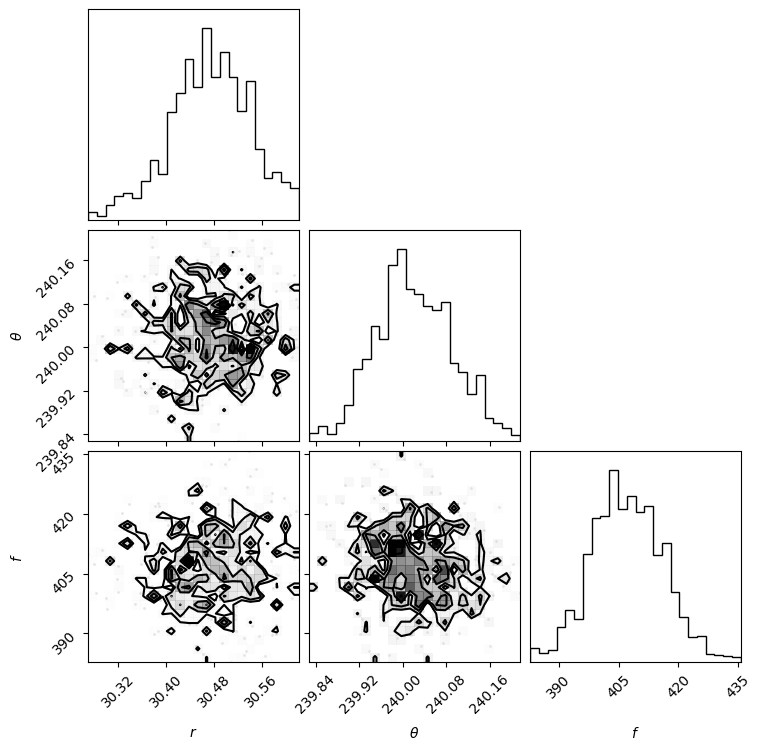

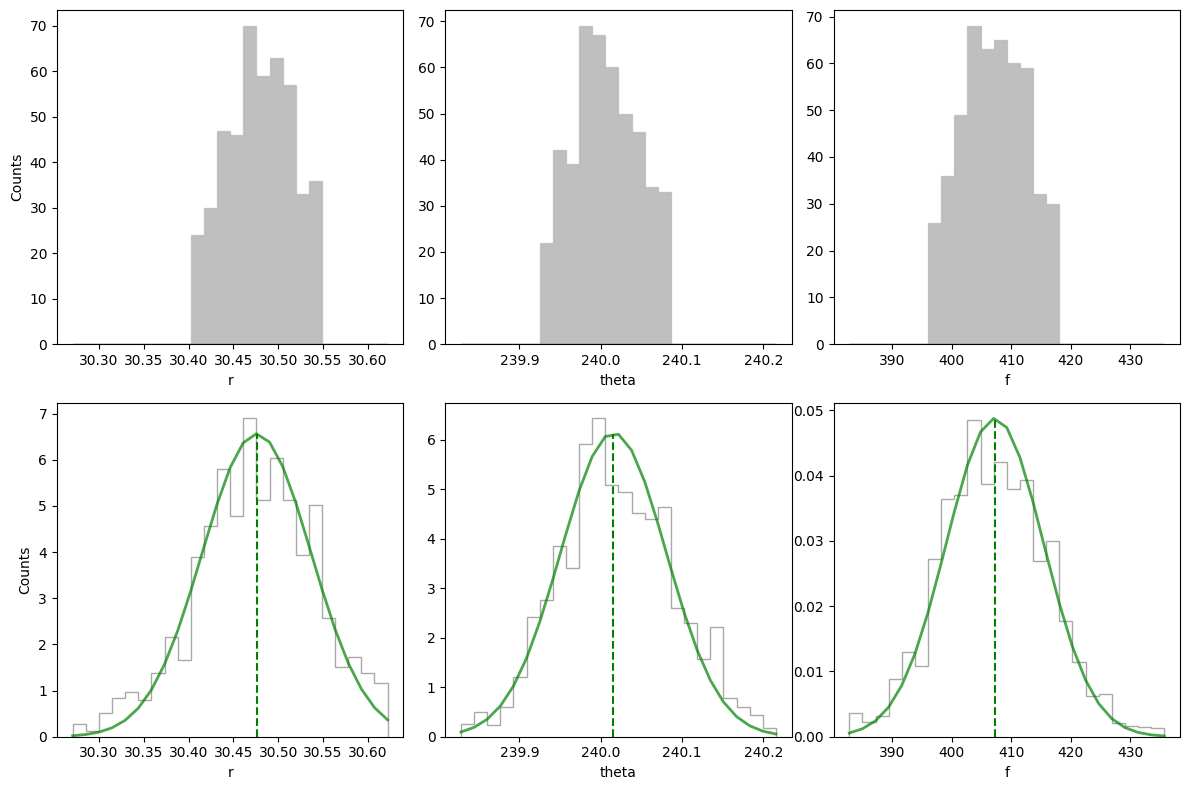

In [47]:
from vip_hci.fm import nested_sampling_results
nested_sampling_results(nested_res, burnin=0.6, bins=None, plot=True, save=True, output_dir='../datasets/')

As a reminder the ground truth values are:

In [48]:
gt

[30.5, 240, 400.0]

The final posterior distributions on the three parameters appear thus reasonable.

### 5.3.5. Residual speckle uncertainty

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="war1"></a>

This section should only be relevant if using `mu_sigma=False` in your call to mcmc_negfc_sampling. If `mu_sigma=True`, the uncertainties inferred with the MCMC should already encompass the residual speckle uncertainty.
</div>

Residual speckle noise can bias the best parameter estimates found for the companion (if not taken into account in the MCMC).
To evaluate the uncertainty associated to this additional source of noise, it is recommended to inject a large number of fake companions at the same radius and flux as estimated for the true companion but different azimuths, and then estimate their parameters using simplex-NEGFC. The distribution of differences with respect to injected parameters can then give us an idea of the *residual speckle noise uncertainty*. This is done in VIP with the `speckle_noise_uncertainty` function (see also Sec. 3.3 in Wertz et al. 2017 for more details).

Let's use the planet parameters inferred by the MCMC-NEGFC algorithm:

In [49]:
pl_par = (val_max['r'],val_max['theta'],val_max['f'])
pl_par

(30.57489764243517, 239.91771004343246, 390.7650582608513)


#######################################################
###            SPECKLE NOISE DETERMINATION          ###
#######################################################

Number of steps: 360

Process is running for angle: 0.00
Process is running for angle: 18.00
Process is running for angle: 36.00
Process is running for angle: 54.00
Process is running for angle: 72.00
Process is running for angle: 1.00
Process is running for angle: 19.00
Process is running for angle: 73.00
Process is running for angle: 55.00
Process is running for angle: 37.00
Process is running for angle: 74.00
Process is running for angle: 2.00
Process is running for angle: 56.00
Process is running for angle: 38.00
Process is running for angle: 20.00
Process is running for angle: 75.00
Process is running for angle: 57.00
Process is running for angle: 39.00
Process is running for angle: 3.00
Process is running for angle: 21.00
Process is running for angle: 76.00
Process is running for angle: 4.00
Process is running fo

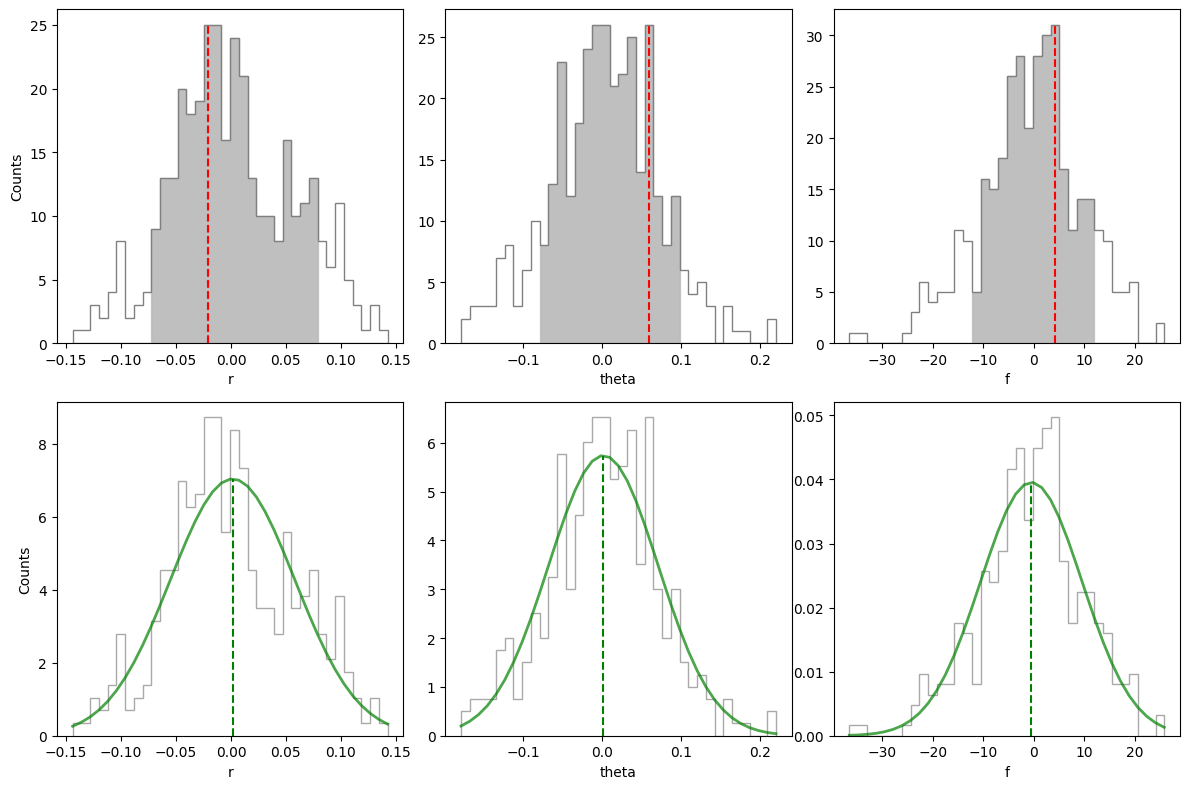

In [50]:
from vip_hci.fm import speckle_noise_uncertainty
algo_options={'ncomp':opt_npc_ann, 'annulus_width':4*fwhm_naco, 'imlib':imlib_rot, 
              'interpolation':interpolation, 'svd_mode':svd_mode}
speckle_res = speckle_noise_uncertainty(cubefc, pl_par, np.linspace(0,359,360), angs, pca_annulus, 
                                        psfn, fwhm_naco, aperture_radius=2, fmerit='sum', 
                                        algo_options=algo_options, transmission=None, mu_sigma=None, 
                                        wedge=None, weights=None, force_rPA=False, nproc=None, 
                                        simplex_options=None, bins=None, save=False, output=None, 
                                        verbose=True, full_output=True, plot=True)

Again, if you wish to write the result (to avoid having to run the previous box again), just set `write=True`. This will pickle the result:

In [51]:
write=False

if write:
    output = {'speckle_res':speckle_res}
    with open('../datasets/my_speckle_residuals_results', 'wb') as fileSave:
        pickle.dump(output, fileSave)

Load pickled results from disk:

In [52]:
with open('../datasets/speckle_residuals_results','rb') as fi:
    myPickler = pickle.Unpickler(fi)
    sp_unc_result = myPickler.load()

print(sp_unc_result.keys())

speckle_res = sp_unc_result['speckle_res']
sp_unc, mean_dev, p_simplex, offset, chi2, nit, success = speckle_res

dict_keys(['speckle_res'])


The speckle uncertainty associated to each parameter is contained in `sp_unc` which corresponds to the 1$\sigma$ width of a Gaussian distribution fitted to the `offset` distribution (i.e. the differences with respect to injected ground truths):

In [53]:
sp_unc

array([ 0.05350939,  0.07376633, 10.64773837])

For comparison, the uncertainties found by the MCMC procedure (which also include Poisson noise) were:

In [54]:
sigma

array([ 0.13676103,  0.15744912, 21.66963444])

### 5.3.6. Final uncertainties

The final uncertainties on the planet parameters should include both **statistical** and **systematic** uncertainties. 
The former include both the *photon noise* and *residual speckle noise* uncertainties discussed above. 
The latter include both the uncertainty on the *star location* (which may be non-negligible when using a coronagraph) and *instrumental calibration errors*, including:

- the uncertainty on the plate scale (for $r$, when converting to angular separation) - note that it is proportional to the radial separation itself;
- the uncertainty on the PA of true north (for $\theta$).

The uncertainty on the star location is of the order of 0.3px in individual NACO+AGPM images (this is the typical precision by manual recentering during the observation). Given the shift plots in `Tutorial 2`, it appears the autocorrelation timescale is of the order of ~5 frames. Therefore, considering that there are 61 frames in the datacube, the uncertainty on the star location in the final combined image must be roughly:

In [55]:
cen_unc_indiv = 0.3 #px
cen_unc = cen_unc_indiv/np.sqrt(61/5) #px
cen_unc

0.08588975014708022

The latter can be translated into an uncertainty on $\theta$ by division by the radial separation of the companion. The stellar centering uncertainties on each planet parameter can thus be expressed as:

In [56]:
star_unc = np.array([cen_unc*pxscale_naco, 
                     np.rad2deg(cen_unc/val_max['r']), 
                     0]) # uncertainty on each of the 3 parameters due to stellar centering

where the multiplication by `pxscale_naco` has converted the radial separation in arcsec.

For the instrumental calibration errors, we adopt the values quoted in Absil et al. (2013). Note that the uncertainty related to the plate scale is directly proportional to the radial separation of the companion.

In [57]:
dr_unc = 0.00004 # plate scale uncertainty in arcsec per px
tn_unc = 0.09    # uncertainty on true north in deg
syst_unc = np.array([val_max['r']*dr_unc, 
                     tn_unc, 
                     0])

The final uncertainties are then the different sources of uncertainty added quadratically - after conversion of the radial separation to arcsec:

In [58]:
sigma[0] *= pxscale_naco
sp_unc[0] *= pxscale_naco

if mu_sigma:
    final_unc = np.sqrt(np.power(sigma,2) + np.power(star_unc,2) + np.power(syst_unc,2))
else:
    final_unc = np.sqrt(np.power(sigma,2) + np.power(sp_unc,2) + np.power(star_unc,2) + np.power(syst_unc,2))

In [59]:
msg = "The final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: \n"
msg+= "r = {:.2f}+-{:.2f} mas (GT: {:.2f} mas), \n"
msg+= "PA = {:.2f}+-{:.2f} deg (GT: {:.2f} deg) \n"
msg+= "f = {:.2f}+-{:.2f} ADUs (GT: {:.2f} ADUs)"
print(msg.format(val_max['r']*pxscale_naco*1000, final_unc[0]*1000, rad_fc*pxscale_naco*1000,
                 val_max['theta'], final_unc[1], theta_fc,
                 val_max['f'], final_unc[2], flux_fc))

The final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: 
r = 831.33+-4.78 mas (GT: 829.29 mas), 
PA = 239.92+-0.25 deg (GT: 240.00 deg) 
f = 390.77+-24.14 ADUs (GT: 400.00 ADUs)


Let's consider the Gaussian fit instead:

In [60]:
msg = "Considering a Gaussian fit to the posterior distributions, the final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: \n"
msg+= "r = {:.2f}+-{:.2f} mas (GT: {:.2f} mas), \n"
msg+= "PA = {:.2f}+-{:.2f} deg (GT: {:.2f} deg) \n"
msg+= "f = {:.2f}+-{:.2f} ADUs (GT: {:.2f} ADUs)"
print(msg.format(mu[0]*pxscale_naco*1000, final_unc[0]*1000, rad_fc*pxscale_naco*1000,
                 mu[1], final_unc[1], theta_fc,
                 mu[2], final_unc[2], flux_fc))

Considering a Gaussian fit to the posterior distributions, the final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: 
r = 830.00+-4.78 mas (GT: 829.29 mas), 
PA = 239.95+-0.25 deg (GT: 240.00 deg) 
f = 394.13+-24.14 ADUs (GT: 400.00 ADUs)
